<a href="https://colab.research.google.com/github/LarsAmker/ExplainGAN/blob/master/Pneumonia_compact_AfterRecon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparations
In oder to prevent Colab from disconnecting when the tab is idle, press Ctrl-Shift-i and enter this:

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}setInterval(ClickConnect,60000)

Mount my google drive to get access to data files and weights stored there

In [1]:
# Colab library to upload files to notebook
from google.colab import files

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

# added tensorflow and stuff from the MNIST classifier:
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
import PIL
import time
from IPython import display

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


NAIN had a code box fixing some random seeds here. Not compatible with tf2 however, therefore deleted and saved in testPneumonia/reproducability

In [3]:
# Clone the github repo to get access to the outsourced building blocks
!git clone https://github.com/LarsAmker/ExplainGAN

Cloning into 'ExplainGAN'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 694 (delta 53), reused 0 (delta 0), pack-reused 603
Receiving objects: 100% (694/694), 2.31 MiB | 12.45 MiB/s, done.
Resolving deltas: 100% (404/404), done.


## Load the preprocessed data and labels

In [0]:
train_data = np.load('/content/gdrive/My Drive/pneumonia_data/train_data.npy')
test_data = np.load('/content/gdrive/My Drive/pneumonia_data/test_data.npy')
valid_data = np.load('/content/gdrive/My Drive/pneumonia_data/valid_data.npy')
train_labels = np.load('/content/gdrive/My Drive/pneumonia_data/train_labels.npy')
test_labels = np.load('/content/gdrive/My Drive/pneumonia_data/test_labels.npy')
valid_labels = np.load('/content/gdrive/My Drive/pneumonia_data/valid_labels.npy')

In [0]:
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)
print(train_labels.shape)
print(test_labels.shape)
print(valid_labels.shape)

The dataset is divided into three sets: 1) train set 2) validation set and 3) test set. Let's grab the dataset

In NAIN's classifier, the training data is handled differently: He just created a dataframe of paths to the images and the labels in a second column. Then he used a data generator for the training. Using the generator in the training of my multi-network ExplainGAN model did not work (or at least I did not figure out how to make it work), so I transfered the data import steps of validation and test data and I do the batching in the way of my MNIST code later on, before the training.

# Classifier (NAIN's depthwise kernel)

Build and compile an empty model and then load the weights for it from my google drive. These weights were created and saved in the notebook "PneumoniaClassifier.ipynb". Later: Try to get the results a bit better and achieve the same quality as NAIN did.

And try NAIN's other kernel (training with focal loss). Its false predictions are more balanced between the 2 classes

In [0]:
%run ExplainGAN/blocksPneumonia/classifier

In [0]:
classifier =  build_model()
#model.summary()

In [0]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
classifier.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [8]:
classifier.load_weights('/content/gdrive/My Drive/Colab Notebooks/DepthwiseWeights')

### Testing classifier
More visualizations like the confusion matrix can be found in testsPneumonia/test_classifier

In [0]:
# Evaluation on test dataset
test_loss, test_score = classifier.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

# ExplainGAN

## Encoder
Maybe change something about the structure here: The Pix2Pix tutorial from TensorFlow (producing great crisp artificial images from similarly sized images) does not use MaxPooling, but accomplishes the dimensionality reduction with stride 2 convolutions. Right now, my convolutions keep the image size the same and the MaxPooling does the dim reduction

In [0]:
#%run ExplainGAN/blocksPneumonia/encoder

In [0]:
# Copied from https://blog.keras.io/building-autoencoders-in-keras.html, added flattening at the end
# Also made activation function variable. Relu has been leading to exploding latent variables at some point

# In comparison to MNIST: Change input shape, but use only one of the three RGB channels
# 20200419: Added one iteration and increased number of filters
def make_encoder_model(activ_fct):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=2, activation=activ_fct, padding='same', use_bias=True,
                                     input_shape=[224, 224, 1]))
    #model.add(layers.MaxPooling2D((2,2), padding='same'))

    model.add(layers.Conv2D(64, (3, 3), strides=2, activation=activ_fct, padding='same', use_bias=True))
    #model.add(layers.MaxPooling2D((2,2), padding='same'))

    model.add(layers.Conv2D(64, (3, 3), strides=2, activation=activ_fct, padding='same', use_bias=True))
    #model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), strides=2, activation=activ_fct, padding='same', use_bias=True))
    #model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), strides=2, activation=activ_fct, padding='same', use_bias=True))
    #model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Flatten())
    
    return model
# At this point the representation is a 1568-vector
# The convolutions here don't decrease the 2D dimension because they have default (1,1) strides. The MaxPooling does

In [0]:
encoder0 = make_encoder_model(activ_fct='relu')
encoder1 = make_encoder_model(activ_fct='relu')
#encoder0.summary()

## Generators

The generator_start is the biggest part of ExplainGAN, i.e. the one with the most weights. I already ran into one OOM error with this version of the code after building ~5 models with 123 millions of weights. The vast majority of weights appears in the very first, dense, layer. 

Make this smaller somehow. Let's try to create fewer 7*7 images (in MNIST, we created 128 of these from an encoded vector of length 128). Try 128 for now. Then we have only 10 millions of weights in generator_start

In [0]:
# This generator is based on the DCGAN generator. But now, we need 3 outputs and not just one!
# Therefore tear it apart in the middle. We will use the second part three times to get recon and trafo and mask 
def make_generator_model_start():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*64, use_bias=False, input_shape=(3136,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Create images of size 7*7 with 64 channels, all connected to the 1568 nodes of the encoded original image
    # In the next 2 lines, the tensor is actually reshaped into that channel form

    model.add(layers.Reshape((7, 7, 64)))
    assert model.output_shape == (None, 7, 7, 64) # Note: None is the batch size

    # now move 5*5*128(channels) filters over the 7*7*128(channels) images in 1,1 strides. Do this for each of the 64 output channels.
    # 64 is the number of different filters we apply. Because of the big number of input channels, each filter is already huge
    # The number of parameters here is 5*5*128 (filter weights) *64 (number of filters)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    return model
    
 
# Now the second part. Apply this three times to get reconstruction and transformation and mask
# Because of the splitting, I also needed to add the input shape in the first layer of this second part.
def make_generator_model_end(activ_fct): 
    # activ_fct is the activation function for the very last layer (sigmoid for mask, tanh for recon and trafo)
    # By taking strides of 2, the size of the image gets doubled in length and width.
    # This is the case, because we do a backwards convolution. If we get a 7*7 image by taking (2,2)-strides, we must have started with 14*14
    model = tf.keras.Sequential()
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=(7,7,64)))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=(14,14,32)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=(28,28,16)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=(56,56,8)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=activ_fct))
    assert model.output_shape == (None, 224, 224, 1)
    return model

In [0]:
generator_start = make_generator_model_start()
#generator_start.summary()
reconstructor = make_generator_model_end(activ_fct='tanh')
transformator = make_generator_model_end(activ_fct='tanh')
mask = make_generator_model_end(activ_fct='sigmoid')
#reconstructor.summary()

## Composite images

In [0]:
# We will need to call this function twice to create a composite image of each class
# orig_image and created_image are always from the two different classes. 
# tf.math.multiply performs an element-wise multiplication
def create_composite(orig_image, created_image, mask):
  composite = tf.add(tf.math.multiply(1-mask,orig_image), tf.math.multiply((mask),created_image))
  return composite

In [0]:
# We can input both RGB images (: in the last argument in the example below) and grayscale images
# The function returns the same format. Just make sure all inputs have this same format
#create_composite(valid_data[0:1,:,:,1],valid_data[4:5,:,:,1], valid_data[2:3,:,:,1]) 

## Discriminators
In difference to MNIST, we now want to share the last few layers of the discriminators for both classes, i.e. use the same network discriminator_end after two separate discriminator_start networks. This is what is desribed in the paper. For MNIST, the discriminators were very small already, so it seemed to not make a big difference.

In [0]:
# Only change in discrimiator_start compared to MNIST: Input shape. Rest stays the same
# But: Extra layer added in discriminator_end to get a deeper network than for MNIST
# Modification: Put sigmoid at the end (nothing there before) to get values between 0 and 1
def make_discriminator_model_start():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=True,
                                     input_shape=[224, 224, 1]))
    # number of params for Conv2D: 64(output channels = number of filters) * 26(filter size 5*5*1 + 1 for a bias node)
    # In contrast to the generator model, we use bias nodes here. 
    # Maybe that would have been useless in the generator because of the batch normalizations
    # They normalize the input anyway, so any bias would get cancelled again
    # We also use dropout here!
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=True))
    # reduced the number of filters from 128 to 64 in reaction to an OOM error when training
    # number of params for this Conv2D: 128(output channels) * 1601(filter size 5*5*64 + 1 for a bias node)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    return model

def make_discriminator_model_end():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=True,
                                     input_shape=[56, 56, 128]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', use_bias=True))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, use_bias=True, activation=tf.nn.sigmoid)) 
  # sigmoid to get value between 0 and 1 (Goodfellow2016 did this in their DCGAN too, so it should be a good idea here)
  
  return model

In [0]:
discriminator0 = make_discriminator_model_start()
discriminator1 = make_discriminator_model_start()
discriminator_end = make_discriminator_model_end()
#discriminator0.summary()

## Loss function and optimizers

In [0]:
%run ExplainGAN/lossesPneumonia/loss_reconstruction
#%run ExplainGAN/lossesPneumonia/loss_gan
%run ExplainGAN/lossesPneumonia/loss_classifier
%run ExplainGAN/lossesPneumonia/losses_prior

In [0]:
# 2-sided smoothing with only 0.05 smoothing
def loss_gan_smoothed(real_output, recon_output, trafo_output, comp_output):
  real_loss = tf.math.log(real_output)*0.95 + tf.math.log(1-real_output)*0.05
  #recon_loss = tf.math.log(1-recon_output)
  recon_loss = 0
  trafo_loss = tf.math.log(1-trafo_output)*0.95 + tf.math.log(trafo_output)*0.05   
  comp_loss = tf.math.log(1-comp_output)*0.95 + tf.math.log(comp_output)*0.05
  return real_loss + recon_loss + trafo_loss + comp_loss

In [0]:
#enc0_optimizer = tf.keras.optimizers.Adam(1e-5)
#enc1_optimizer = tf.keras.optimizers.Adam(1e-5)
#gen_start_optimizer = tf.keras.optimizers.Adam(1e-5)
#recon_optimizer = tf.keras.optimizers.Adam(1e-5)
trafo_optimizer = tf.keras.optimizers.Adam(5e-5)
mask_optimizer = tf.keras.optimizers.Adam(1e-4)
disc0_optimizer = tf.keras.optimizers.Adam(2e-5)
disc1_optimizer = tf.keras.optimizers.Adam(2e-5)
disc_end_optimizer = tf.keras.optimizers.Adam(2e-5)

##Training

In [0]:
# Changes compared to the DCGAN version: test_input is the first real image(s) instead of a random seed
def generate_and_save_images(epoch, test_input, index):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  original = test_input[index:index+1,:,:,:]
  prediction = classifier.predict(original)
  prediction = np.argmax(prediction, axis=1)
  if prediction == 0:
    z = encoder0(original[:,:,:,1], training=False)
  if prediction == 1:
    z = encoder1(original[:,:,:,1], training=False)
  gen_from_pred = generator_start(z, training=False)
  recon_from_pred = reconstructor(gen_from_pred, training=False)
  trafo_from_pred = transformator(gen_from_pred, training=False)
  mask_from_pred = mask(gen_from_pred, training=False)
  comp_from_pred = create_composite(original, trafo_from_pred, mask_from_pred)
  
  fig = plt.figure(figsize=(20,20))
  plt.subplot(1, 5, 1)
  plt.imshow(original[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.subplot(1, 5, 2)
  plt.imshow(recon_from_pred[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.subplot(1, 5, 3)
  plt.imshow(trafo_from_pred[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.subplot(1, 5, 4)
  plt.imshow(mask_from_pred[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.subplot(1, 5, 5)
  plt.imshow(comp_from_pred[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train_step(images, weight_g, weight_c, weight_r, weight_cs, weight_ct, weight_sm, weight_en, kappa, pretraining_flag):
  predicted_classes = classifier.predict(images) # classifier model takes (224,224,3) as input
  predicted_classes = np.argmax(predicted_classes, axis=1) # now we have the actual predictions
  predicted_classes = tf.reshape(predicted_classes, [-1,1]) # make it compatible with tensors below
  predicted_classes = tf.cast(predicted_classes, tf.float32) # change type to float for multiplications
  
  images_grayscale = images[:,:,:,0:1] # everything works on grayscale images -> Use these from now on.
  # Every image produced is grayscale unless its name indicates RGB

  with tf.GradientTape() as trafo_tape, tf.GradientTape() as mask_tape, tf.GradientTape() as disc0_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc_end_tape:
    z_as0 = encoder0(images_grayscale)
    z_as1 = encoder1(images_grayscale)
    gen_from_pred0 = generator_start(z_as0)
    gen_from_pred1 = generator_start(z_as1)
    recon_from_pred0 = reconstructor(gen_from_pred0)
    recon_from_pred1 = reconstructor(gen_from_pred1)
    trafo_from_pred0 = transformator(gen_from_pred0)
    trafo_from_pred1 = transformator(gen_from_pred1)
    mask_from_pred0 = mask(gen_from_pred0)
    mask_from_pred1 = mask(gen_from_pred1) 
    comp_from_pred0 = create_composite(images_grayscale, trafo_from_pred0, mask_from_pred0)
    comp_from_pred1 = create_composite(images_grayscale, trafo_from_pred1, mask_from_pred1)
    #print("recon0 shape:", recon_from_pred0.shape)

    # In comparison to MNIST, the discriminators got split up in two networks. Consequence: Extra stepts here
    #real_output0_step = discriminator0(images_grayscale)
    #real_output1_step = discriminator1(images_grayscale)
    #recon_output0_step = discriminator0(recon_from_pred0)
    #recon_output1_step = discriminator1(recon_from_pred1)
    #trafo_output0_step = discriminator1(trafo_from_pred0) # now use the opposite discriminators
    #trafo_output1_step = discriminator0(trafo_from_pred1)
    #comp_output0_step = discriminator1(comp_from_pred0)
    #comp_output1_step = discriminator0(comp_from_pred1)

    real_output0 = discriminator_end(discriminator0(images_grayscale))
    real_output1 = discriminator_end(discriminator1(images_grayscale))
    recon_output0 = discriminator_end(discriminator0(recon_from_pred0))
    recon_output1 = discriminator_end(discriminator1(recon_from_pred1))
    trafo_output0 = discriminator_end(discriminator1(trafo_from_pred0))
    trafo_output1 = discriminator_end(discriminator0(trafo_from_pred1))
    comp_output0 = discriminator_end(discriminator1(comp_from_pred0))
    comp_output1 = discriminator_end(discriminator0(comp_from_pred1))

    # Losses
    # GAN loss
    loss_gan_pred0 = loss_gan_smoothed(real_output0, recon_output0, trafo_output0, comp_output0)
    loss_gan_pred1 = loss_gan_smoothed(real_output1, recon_output1, trafo_output1, comp_output1)
    loss_g0 = tf.math.multiply(1-predicted_classes, loss_gan_pred0)
    loss_g1 = tf.math.multiply(predicted_classes, loss_gan_pred1)
    loss_g = (loss_g0 + loss_g1) * weight_g

    # Classifier loss - first we need to create predictions for our composite images
    # Here we need RGB images again. Transform the grayscale composites to RGB first
    comp_from_pred0_RGB = np.stack([comp_from_pred0[:,:,:,0], comp_from_pred0[:,:,:,0], comp_from_pred0[:,:,:,0]], axis=3) 
    comp_from_pred1_RGB = np.stack([comp_from_pred1[:,:,:,0], comp_from_pred1[:,:,:,0], comp_from_pred1[:,:,:,0]], axis=3)
    
    pred_comp_from_pred0 = classifier(comp_from_pred0_RGB) # RGB input for classifier
    pred_comp_from_pred0 = pred_comp_from_pred0[:,1] # not argmax here, we need the probability of pneumonia
    pred_comp_from_pred0 = tf.reshape(pred_comp_from_pred0, [-1,1])
    pred_comp_from_pred0 = tf.cast(pred_comp_from_pred0, tf.float32)
    pred_comp_from_pred1 = classifier(comp_from_pred1_RGB) # RGB input for classifier
    pred_comp_from_pred1 = pred_comp_from_pred1[:,1] # not argmax here, we need the probability
    pred_comp_from_pred1 = tf.reshape(pred_comp_from_pred1, [-1,1])
    pred_comp_from_pred1 = tf.cast(pred_comp_from_pred1, tf.float32)
    # now calculate the loss
    loss_class_pred0 = loss_classifier0(pred_comp_from_pred0) 
    loss_class_pred1 = loss_classifier1(pred_comp_from_pred1)
    loss_c0 = tf.math.multiply(1-predicted_classes, loss_class_pred0)
    loss_c1 = tf.math.multiply(predicted_classes, loss_class_pred1)
    loss_c = (loss_c0 + loss_c1) * weight_c

    # Recon loss
    #loss_recon0 = loss_recon(images_grayscale, recon_from_pred0)
    #loss_recon1 = loss_recon(images_grayscale, recon_from_pred1)
    #print("loss_recon0 shape:", loss_recon0.shape)
    #loss_r0 = tf.math.multiply(1-predicted_classes, loss_recon0) # set the loss for the wrong recons to 0
    #loss_r1 = tf.math.multiply(predicted_classes, loss_recon1) # set the loss for the wrong recons to 0
    #loss_r = (loss_r0 + loss_r1) * weight_r

    # The 4 prior losses
    #print('mask shape:', mask_from_pred0.shape)
    loss_const0 = loss_const(images_grayscale, trafo_from_pred0, mask_from_pred0)
    loss_const1 = loss_const(images_grayscale, trafo_from_pred1, mask_from_pred1)
    loss_cs0 = tf.math.multiply(1-predicted_classes, loss_const0)
    loss_cs1 = tf.math.multiply(predicted_classes, loss_const1)
    loss_cs = (loss_cs0 + loss_cs1) * weight_cs
    loss_count0 = loss_count(mask_from_pred0, kappa)
    loss_count1 = loss_count(mask_from_pred1, kappa)
    loss_ct0 = tf.math.multiply(1-predicted_classes, loss_count0)
    loss_ct1 = tf.math.multiply(predicted_classes, loss_count1)
    loss_ct = (loss_ct0 + loss_ct1) * weight_ct
    loss_smooth0 = loss_smoothness(mask_from_pred0)
    loss_smooth1 = loss_smoothness(mask_from_pred1)
    loss_sm0 = tf.math.multiply(1-predicted_classes, loss_smooth0)
    loss_sm1 = tf.math.multiply(predicted_classes, loss_smooth1)
    loss_sm = (loss_sm0 + loss_sm1) * weight_sm
    loss_entropy0 = loss_entropy(mask_from_pred0)
    loss_entropy1 = loss_entropy(mask_from_pred1)
    loss_en0 = tf.math.multiply(1-predicted_classes, loss_entropy0)
    loss_en1 = tf.math.multiply(predicted_classes, loss_entropy1)
    loss_en = (loss_en0 + loss_en1) * weight_en
    loss_prior = loss_cs + loss_ct + loss_sm + loss_en
    
    # Add up losses that are used together
    loss_r = 0
    #loss_c = 0
    #loss_prior = 0
    loss_summed = loss_g + loss_r + loss_c
    #print("loss_summed shape:", loss_summed.shape)

    #gradients_of_enc0 = enc0_tape.gradient(loss_summed, encoder0.trainable_variables)
    #gradients_of_enc1 = enc1_tape.gradient(loss_summed, encoder1.trainable_variables)
    #gradients_of_gen_start = gen_start_tape.gradient(loss_summed, generator_start.trainable_variables)
    #gradients_of_recon = recon_tape.gradient(loss_summed, reconstructor.trainable_variables)
    gradients_of_trafo = trafo_tape.gradient(loss_g + loss_c + loss_cs, transformator.trainable_variables)
    gradients_of_mask = mask_tape.gradient(loss_prior + loss_g + loss_c, mask.trainable_variables)
    gradients_of_disc0 = disc0_tape.gradient(-loss_g, discriminator0.trainable_variables)
    gradients_of_disc1 = disc1_tape.gradient(-loss_g, discriminator1.trainable_variables)
    gradients_of_disc_end = disc_end_tape.gradient(-loss_g, discriminator_end.trainable_variables)

    #enc0_optimizer.apply_gradients(zip(gradients_of_enc0, encoder0.trainable_variables))
    #enc1_optimizer.apply_gradients(zip(gradients_of_enc1, encoder1.trainable_variables))
    #gen_start_optimizer.apply_gradients(zip(gradients_of_gen_start, generator_start.trainable_variables))
    #recon_optimizer.apply_gradients(zip(gradients_of_recon, reconstructor.trainable_variables))
    trafo_optimizer.apply_gradients(zip(gradients_of_trafo, transformator.trainable_variables))
    mask_optimizer.apply_gradients(zip(gradients_of_mask, mask.trainable_variables))
    disc0_optimizer.apply_gradients(zip(gradients_of_disc0, discriminator0.trainable_variables))      
    disc1_optimizer.apply_gradients(zip(gradients_of_disc1, discriminator1.trainable_variables))
    disc_end_optimizer.apply_gradients(zip(gradients_of_disc_end, discriminator_end.trainable_variables))

    print('###################################################################################')
    print('real_output0: ', tf.reduce_max(real_output0), tf.reduce_min(real_output0), tf.reduce_mean(real_output0))
    print('real_output1: ', tf.reduce_max(real_output1), tf.reduce_min(real_output1), tf.reduce_mean(real_output1))
    #print('recon_output0: ', tf.reduce_max(recon_output0), tf.reduce_min(recon_output0), tf.reduce_mean(recon_output0))
    print('trafo_output0: ', tf.reduce_max(trafo_output0), tf.reduce_min(trafo_output0), tf.reduce_mean(trafo_output0))
    print('trafo_output1: ', tf.reduce_max(trafo_output1), tf.reduce_min(trafo_output1), tf.reduce_mean(trafo_output1))
    print('comp_output0: ', tf.reduce_max(comp_output0), tf.reduce_min(comp_output0), tf.reduce_mean(comp_output0))
    print('comp_output1: ', tf.reduce_max(comp_output1), tf.reduce_min(comp_output1), tf.reduce_mean(comp_output1))
    print('loss_g: ', tf.reduce_max(loss_g), tf.reduce_min(loss_g), tf.reduce_mean(loss_g))
    print('loss_c: ', tf.reduce_max(loss_c), tf.reduce_min(loss_c), tf.reduce_mean(loss_c))
    #print('loss_r: ', tf.reduce_max(loss_r), tf.reduce_min(loss_r), tf.reduce_mean(loss_r))
    print('loss_cs: ', tf.reduce_max(loss_cs), tf.reduce_min(loss_cs), tf.reduce_mean(loss_cs))
    print('loss_ct: ', tf.reduce_max(loss_ct), tf.reduce_min(loss_ct), tf.reduce_mean(loss_ct))
    print('loss_sm: ', tf.reduce_max(loss_sm), tf.reduce_min(loss_sm), tf.reduce_mean(loss_sm))
    print('loss_en: ', tf.reduce_max(loss_en), tf.reduce_min(loss_en), tf.reduce_mean(loss_en))

In [0]:
weight_g = 0.1
weight_c = 1.25
weight_r = 0.0001
weight_cs = 0.001
weight_ct = 2
weight_sm = 0.015
weight_en = 0.05 
kappa = 0.05
pretraining_flag = 2

In [0]:
# Checking, seems to work just fine. Loss changes from step to step
#train_step(test_data) # produces OOM error
#train_step(valid_data) # still works
#train_step(train_data[0:2,:,:,:], weight_g, weight_c, weight_r, weight_cs, weight_ct, weight_sm, weight_en, kappa, pretraining_flag) # works

In [0]:
# Batch and shuffle the training (and test - just for experiments) data
# We can play around with the batch size a bit
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(len(train_labels)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).shuffle(len(test_labels)).batch(BATCH_SIZE)
EPOCHS = 25
# batches have the correct shape for the train_step

In [0]:
def train(dataset, epochs, weight_g, weight_c, weight_r, weight_cs, weight_ct, weight_sm, weight_en, kappa, pretraining_flag):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      # Here we use the batching of the dataset
      # call the function train_step (defined in the longest code box)
      train_step(image_batch, weight_g, weight_c, weight_r, weight_cs, weight_ct, weight_sm, weight_en, kappa, pretraining_flag)

    # Produce images for the GIF as we go (from DCGAN)
    #display.clear_output(wait=True)
    generate_and_save_images(epoch + 1, train_data, index=0) # still input train_images here. Would be nice to use dataset instead!!
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)

In [27]:
# OOM error in the training step when loading old weights before.
# Try to avoid training in more than one session
encoder0.compile
encoder1.compile
generator_start.compile
reconstructor.compile
transformator.compile
mask.compile
discriminator0.compile
discriminator1.compile
discriminator_end.compile

encoder0.load_weights('/content/gdrive/My Drive/Colab Notebooks/encoder0_ReconOnly')
encoder1.load_weights('/content/gdrive/My Drive/Colab Notebooks/encoder1_ReconOnly')
generator_start.load_weights('/content/gdrive/My Drive/Colab Notebooks/generator_start_ReconOnly')
reconstructor.load_weights('/content/gdrive/My Drive/Colab Notebooks/reconstructor_ReconOnly')
transformator.load_weights('/content/gdrive/My Drive/Colab Notebooks/transformator_0519')
mask.load_weights('/content/gdrive/My Drive/Colab Notebooks/mask_0519')
discriminator0.load_weights('/content/gdrive/My Drive/Colab Notebooks/discriminator0_0519')
discriminator1.load_weights('/content/gdrive/My Drive/Colab Notebooks/discriminator1_0519')
discriminator_end.load_weights('/content/gdrive/My Drive/Colab Notebooks/discriminator_end_0519')

In [0]:
train(train_dataset, EPOCHS, weight_g, weight_c, weight_r, weight_cs, weight_ct, weight_sm, weight_en, kappa, pretraining_flag)
# Batch size 16 and 8 respectively:
# OOM error in the first layer of the classifier itself when allocating tensor with shape [8or16,224,224,64]
# If the classifier itself (100M parameters) is the problem, my ExplainGAN can maybe grow again
# Batch size 6 still works. 8 also worked again one time

###################################################################################
real_output0:  tf.Tensor(0.99307406, shape=(), dtype=float32) tf.Tensor(0.06880845, shape=(), dtype=float32) tf.Tensor(0.6468223, shape=(), dtype=float32)
real_output1:  tf.Tensor(0.9866014, shape=(), dtype=float32) tf.Tensor(0.41386858, shape=(), dtype=float32) tf.Tensor(0.8147523, shape=(), dtype=float32)
trafo_output0:  tf.Tensor(0.7468141, shape=(), dtype=float32) tf.Tensor(0.017023193, shape=(), dtype=float32) tf.Tensor(0.29696923, shape=(), dtype=float32)
trafo_output1:  tf.Tensor(0.16726588, shape=(), dtype=float32) tf.Tensor(0.019993763, shape=(), dtype=float32) tf.Tensor(0.07483147, shape=(), dtype=float32)
comp_output0:  tf.Tensor(0.85475445, shape=(), dtype=float32) tf.Tensor(0.055184666, shape=(), dtype=float32) tf.Tensor(0.41714567, shape=(), dtype=float32)
comp_output1:  tf.Tensor(0.5034758, shape=(), dtype=float32) tf.Tensor(0.024290713, shape=(), dtype=float32) tf.Tensor(0.18786457, shap

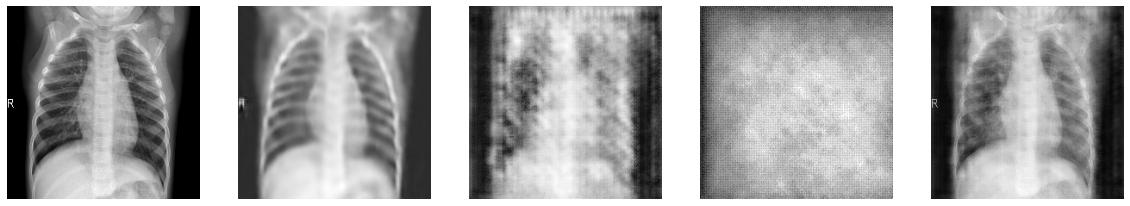

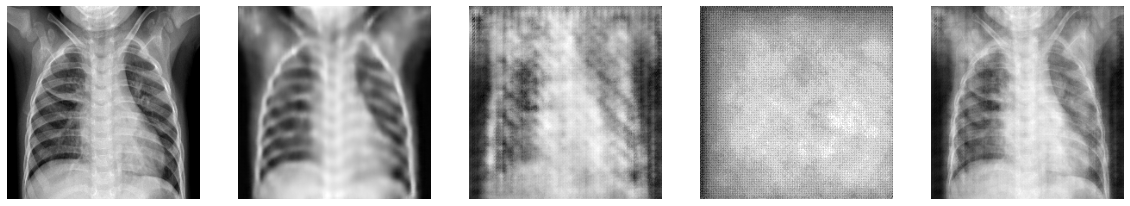

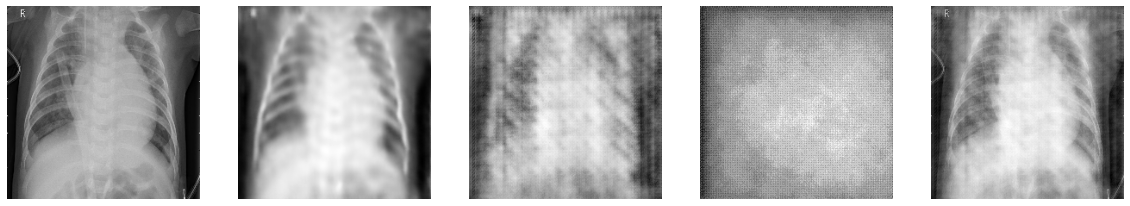

In [26]:
set = test_data
generate_and_save_images(1,set,index=20)
generate_and_save_images(1,set,index=621)
generate_and_save_images(1,set,index=622)

In [0]:
#encoder0.save_weights('/content/gdrive/My Drive/Colab Notebooks/encoder0_0517')
#encoder1.save_weights('/content/gdrive/My Drive/Colab Notebooks/encoder1_0517')
#generator_start.save_weights('/content/gdrive/My Drive/Colab Notebooks/generator_start_0517')
#reconstructor.save_weights('/content/gdrive/My Drive/Colab Notebooks/reconstructor_0517')
transformator.save_weights('/content/gdrive/My Drive/Colab Notebooks/transformator_0520')
mask.save_weights('/content/gdrive/My Drive/Colab Notebooks/mask_0520')
discriminator0.save_weights('/content/gdrive/My Drive/Colab Notebooks/discriminator0_0520')
discriminator1.save_weights('/content/gdrive/My Drive/Colab Notebooks/discriminator1_0520')
discriminator_end.save_weights('/content/gdrive/My Drive/Colab Notebooks/discriminator_end_0520')